# COMPUTATIONAL COSMOLOGY
---
This project has been developed for the course Cosmology within the Master’s Degree in Physics at the University of Valencia. Its objective is to demonstrate the use of standard scientific libraries together with specialized astrophysical libraries in computational cosmology. The project applies numerical and data analysis techniques commonly used in modern cosmological research. It illustrates how these tools can be integrated to model cosmological scenarios and analyze data.

### Authors
- Alejandro Estellés Roig (aesroig@alumni.uv.es)
- Juan Ramón Díaz Santos (diazjuan@alumni.uv.es)

# CMB Power Spectrum Analysis
---
This notebook performs an analysis of the Cosmic Microwave Background (CMB) angular power spectrum using the healpy library. The spectrum is computed from spherical sky maps and represented in terms of its multipole moments. From the resulting power spectrum, the main acoustic peaks are identified and their physical significance is examined. These features are then used to extract relevant cosmological information encoded in the angular power distribution.

## 0. Libraries and System Configuration

### HEALPY
---
**healpy**

healpy is the Python (Cython-based) wrapper for HEALPix (Hierarchical Equal Area iso-Latitude Pixelization), the standard scheme for sampling functions on the sphere widely used in Cosmic Microwave Background (CMB) analysis, notably in missions such as Planck and WMAP. 

- It provides highly optimized tools for spherical data manipulation and enables the fast and efficient computation of angular power spectra and related quantities.
- healpy does not natively support the Windows operating system; in such cases, alternatives such as astropy-healpix can be used. In addition, it may present compatibility issues with certain versions of NumPy and SciPy, which require careful environment management.
- Despite these limitations, healpy remains a reference library for high-performance spherical harmonic analysis in computational cosmology.

### 0.1. Libraries

In [1]:
import os
import time
from datetime import datetime
import requests
from urllib.parse import urljoin

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from scipy.signal import find_peaks
try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False

try:
    import healpy as hp
    _HAS_HEALPY = True
except:
    from joblib import Parallel, delayed
    from scipy.special import sph_harm
    from astropy_healpix import HEALPix
    _HAS_HEALPY = False


### 0.2 Check System
---
- Check if CUDA is available and test availables GPU/VRAM resources
- Check Healpy library

In [2]:
print('\nTorch/CUDA Info:\n-----------------------')
if _HAS_TORCH:
    cuda = torch.cuda.is_available()
    print('Torch Version:', torch.__version__)
    print('Torch CUDA available:', cuda)
    if cuda:
        print("torch_cuda_version:",torch.version.cuda)
        ngpu = torch.cuda.device_count()
        for i in range(ngpu):
            print("Index:", i,"| Name:", torch.cuda.get_device_name(i),
                "| Capability:", "".join(str(x) for x in torch.cuda.get_device_capability(i)),
                "| Total Memory (GB):", "{:.2f}".format(torch.cuda.get_device_properties(i).total_memory/1024**3))
print('\nModule Version:\n-----------------------')
if _HAS_HEALPY:
    print('healpy library is available and loaded')
    for module, name in zip([hp, np],["healpy","numpy"]):
        print(name,'version:', module.__version__)
else:
    for module, name in zip([scipy, np],["scipy","numpy"]):
        print(name,'version:', module.__version__)


Torch/CUDA Info:
-----------------------
Torch Version: 2.2.0+cu121
Torch CUDA available: True
torch_cuda_version: 12.1
Index: 0 | Name: NVIDIA GeForce GTX 1080 Ti | Capability: 61 | Total Memory (GB): 11.00

Module Version:
-----------------------
healpy library is available and loaded
healpy version: 1.18.1
numpy version: 1.26.4


### 1. Download of CMB Data Files

Several download options are available from public repositories.

1. **Planck Legacy Archive (ESA)** – Official archive of the Planck mission, providing full-sky CMB temperature and polarization maps, masks, and component-separated products (SMICA, NILC, SEVEM, COMMANDER).
https://pla.esac.esa.int/

3. **IRSA– NASA/IPAC** Infrared Science Archive – Hosts high-resolution full-sky CMB maps derived from Planck data in HEALPix FITS format, including temperature, polarization, and masks.
https://irsa.ipac.caltech.edu/

4. **NASA LAMBDA** (Legacy Archive for Microwave Background Data Analysis) – Centralized archive for CMB data from Planck, WMAP, and COBE, including maps, power spectra, and documentation.
https://lambda.gsfc.nasa.gov/

5. **ESA Sky** – Interactive astronomy portal that provides access and visualization of Planck CMB products alongside other ESA mission data.
https://sky.esa.int/
---
In this project we are selected  the **IRSA – NASA/IPAC** Infrared Science Archive because
- Provides full-sky, high-resolution CMB maps based on data from the Planck satellite.
- Download format: HEALPix FITS.
- Maps available in the archive:

    * I_STOKES: Intensity map (temperature fluctuation map).
    * Q_STOKES and U_STOKES: Polarization maps.
    * TMASK and PMASK: Galactic masks for temperature and polarization.
- Available processing pipelines:
    * COMMANDER
    * NILC,
    * SEVEM
    * SMICA (recommended).

### 1.1. CMB Download Parameters

In [3]:
# SELECT REPOSITORY
DOWNLOAD_OPTION = 'IRSA'
# SELECT PIPELINE
IRSA_PIPELINE   = 'smica'   # options: 'commander', 'nilc', 'sevem', 'smica'


### 1.2. IRSA CMB Maps Download
---
#### REPOSITORIE: Planck Public Data Release 2 Maps
**DATA SERVER**
- https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/matrix_cmb.html?utm_source=chatgpt.com

**Documentation**
- https://irsa.ipac.caltech.edu/data/Planck/release_2/docs/index.html



In [4]:
if DOWNLOAD_OPTION == 'IRSA':
    # Select the Planck component-separation pipeline to be used
    # Available options: 'commander', 'nilc', 'sevem', 'smica'
    pipeline = 'smica'
    
    # Base URL of the IRSA (NASA/IPAC) archive
    web_url = "https://irsa.ipac.caltech.edu"
    
    # Path to the Planck Release 3 CMB component maps
    release_url = web_url + "/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/"
    
    # Construct the FITS filename according to the selected pipeline
    file_name = "".join(['COM_CMB_IQU-', IRSA_PIPELINE, '_2048_R3.00_full.fits'])
    
    # Build the full URL for downloading the FITS file
    fits_url = os.path.join(release_url, file_name)
    
    # Local name for the downloaded FITS file
    fits_file = os.path.join('/home/juan/cosmo',file_name)
print('URL FITS File:\n', fits_url)
print('\nLocal FITS File:\n', fits_file)

URL FITS File:
 https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits

Local FITS File:
 /home/juan/cosmo/COM_CMB_IQU-smica_2048_R3.00_full.fits


In [5]:
def download_fits(url, file):
    """
    Download a FITS file from the given URL if it does not already exist locally.
    Includes safety checks to avoid saving HTML preview pages by mistake.
    """
    
    # Avoid re-downloading
    if os.path.exists(file):
        print(f"The file '{file}' is already downloaded.")
        return

    headers = {"User-Agent": "Mozilla/5.0", "Accept": "*/*"}

    resp = requests.get(url, stream=True, headers=headers, allow_redirects=True)
    resp.raise_for_status()

    # 1) Quick check: content-type should NOT be HTML
    ctype = resp.headers.get("Content-Type", "").lower()
    if "text/html" in ctype:
        raise RuntimeError(
            "HTML received instead of FITS. URL is likely pointing to a directory or preview page.\n"
            f"Final URL: {resp.url}"
        )

    # 2) Strong check: FITS files usually start with ASCII 'SIMPLE  ='
    # Read a small chunk without consuming the whole stream
    first_bytes = resp.raw.read(80, decode_content=True)
    if b"SIMPLE" not in first_bytes:
        raise RuntimeError(
            "The downloaded content does not look like a FITS file header.\n"
            f"Final URL: {resp.url}\n"
            "Tip: ensure the URL ends with '.fits' and comes from the /maps/... directory, not /previews/."
        )

    # Write the initial bytes + the rest of the stream to disk
    with open(file, "wb") as f:
        f.write(first_bytes)
        for chunk in resp.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

    print(f"Download finished: {file}")

In [6]:
# ---- Build the FITS Local File from FITS URL ----
download_fits(fits_url, fits_file)


The file '/home/juan/cosmo/COM_CMB_IQU-smica_2048_R3.00_full.fits' is already downloaded.


### 1.3. Analysis of the FITS File Header and Map Loading
---
- The primary FITS header is extracted in order to inspect and display its first entries, providing basic metadata about the dataset.
- The CMB maps are then loaded and organized into a dictionary structure for convenient access and further analysis.

In [7]:
# Open FITS
hdul = fits.open(fits_file)

# Define which fields exist in this file (typical for COM_CMB_IQU-... files)
mapas = {
    'I_STOKES': 0,  # Temperature (Intensity)
    'Q_STOKES': 1,  # Polarization Q
    'U_STOKES': 2,  # Polarization U
    'TMASK': 3,     # Temperature Mask
    'PMASK': 4     # Polarization Mask
}

# Load maps into a dictionary
maps = {}
for name, field_idx in mapas.items():
    try:
        maps[name] = hp.read_map(fits_file, field=field_idx)
    except Exception as e:
        print(f'Map {name} not found in FITS file')

# Extract temperature map
I_map = maps['I_STOKES']

# Infer nside from the map itself (no hardcoding)
nside = hp.get_nside(I_map)

# Print primary header (first lines)
print("\n=== Primary Header (First Lines only) ===\n", "-" * 40)
print(repr(hdul[0].header))

# Print basic map stats
print('Loading CMB maps...')
print(f"\n - Loaded I map: nside={nside}, npix={len(I_map)}, "
      f"temperature range: {I_map.min():.2f} to {I_map.max():.2f} μK")
for ix, (name, field) in enumerate(mapas.items()):
    print(f" - Loaded {name}: nside={nside}, npix={len(I_map)} ")



=== Primary Header (First Lines only) ===
 ----------------------------------------
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2018-04-20T13:01:36' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
Loading CMB maps...

 - Loaded I map: nside=2048, npix=50331648, temperature range: -0.01 to 0.01 μK
 - Loaded I_STOKES: nside=2048, npix=50331648 
 - Loaded Q_STOKES: nside=2048, npix=50331648 
 - Loaded U_STOKES: nside=2048, npix=50331648 
 - Loaded TMASK: nside=2048, npix=50331648 
 - Loaded PMASK: nside=2048, npix=50331648 


## 2.Map Visualization
---

### 2.1. Auxiliary Functions
---


In [8]:
# ------------------------------------------------------------
#  Q/U → E/B map conversion
# ------------------------------------------------------------
def qu_to_eb_maps(Q, U, lmax=None):
    """
    Convert Q and U Stokes parameter maps into E and B mode maps
    using spin-2 spherical harmonics.
    Returns E and B maps with the same NSIDE as the input maps.
    """
    # Extract HEALPix resolution from input map
    nside = hp.get_nside(Q)
    
    # Set maximum multipole if not provided (Nyquist limit for HEALPix)
    if lmax is None:
        lmax = 3 * nside - 1

    # Compute spin-2 spherical harmonic coefficients from Q and U
    # almE and almB correspond to E-mode and B-mode coefficients
    almE, almB = hp.map2alm_spin([Q, U], spin=2, lmax=lmax)

    # Reconstruct real-space E and B maps from harmonic coefficients
    E = hp.alm2map(almE, nside=nside, lmax=lmax)
    B = hp.alm2map(almB, nside=nside, lmax=lmax)

    return E, B


# ------------------------------------------------------------
#  Mollweide visualization and masked versions
# ------------------------------------------------------------
def show_map(m, title="", unit="", coord='G', minmax=None, cmap='coolwarm'):
    """
    Display a HEALPix map using Mollweide projection.
    
    Parameters:
    - m      : input HEALPix map
    - title  : plot title
    - unit   : physical units (e.g., μK)
    - coord  : coordinate system ('G' = Galactic, 'C' = Equatorial, 'E' = Ecliptic)
    - minmax : (vmin, vmax) tuple for color scale, or None for automatic scaling
    - cmap   : matplotlib colormap
    """
    # Default color scale limits
    vmin, vmax = (None, None)
    
    # If user provides limits, apply them
    if minmax is not None:
        vmin, vmax = minmax

    # Plot the map in Mollweide projection
    hp.mollview(m, coord=coord, title=title, unit=unit,
                min=vmin, max=vmax, cmap=cmap)

    # Overlay latitude and longitude grid
    hp.graticule()


### 2.2. Intensity Map (I_STOKES) - CMB Temperature Anisotropies
---
- This visualization shows the Stokes I map, which represents the temperature anisotropies of the Cosmic Microwave Background over the full sky. 
- The Mollweide projection provides a global view of the large-scale angular structure of the intensity field.

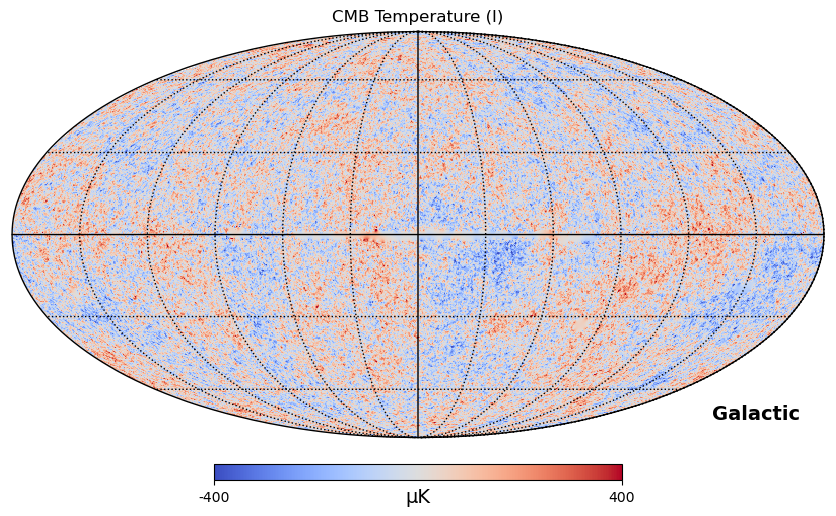

In [9]:
I = maps['I_STOKES']*1e6
I_min = maps['I_STOKES'].min()
I_max = maps['I_STOKES'].max()
show_map(I, title="CMB Temperature (I)", unit="μK", coord='G', minmax=(-400,400))


### 2.3. Polarization Map (Q_STOKES)
---
This visualization displays the Stokes Q polarization map, which encodes one of the linear polarization components of the Cosmic Microwave Background. It highlights the directional dependence of the polarization field and its variation across the sky

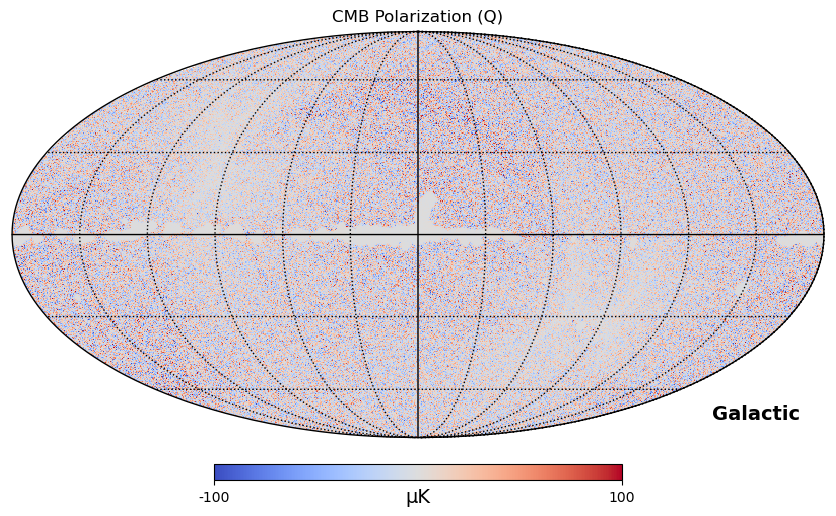

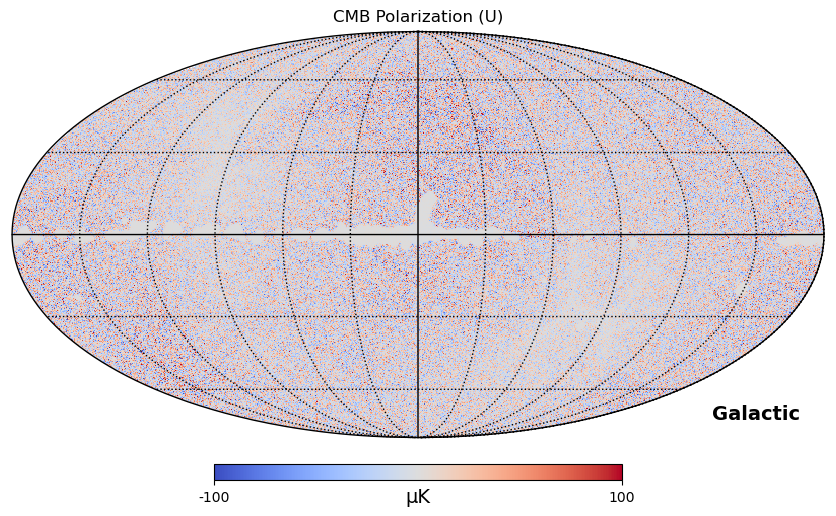

In [10]:
Q = maps['Q_STOKES']*1e6
Q_min = maps['Q_STOKES'].min()
Q_max = maps['Q_STOKES'].max()
show_map(Q, title="CMB Polarization (Q)", unit="μK", coord='G', minmax=(-100,100))

U = maps['U_STOKES']*1e6
U_min = maps['U_STOKES'].min()
U_max = maps['U_STOKES'].max()
show_map(U, title="CMB Polarization (U)", unit="μK", coord='G', minmax=(-100,100))

### 2.4. Polarization (E/B)
---
This visualization shows the E-mode and B-mode polarization maps derived from the Stokes Q and U fields. The E-mode map reflects the scalar density perturbations of the early Universe, while the B-mode map traces curl-like polarization patterns associated with tensor perturbations and lensing effects.

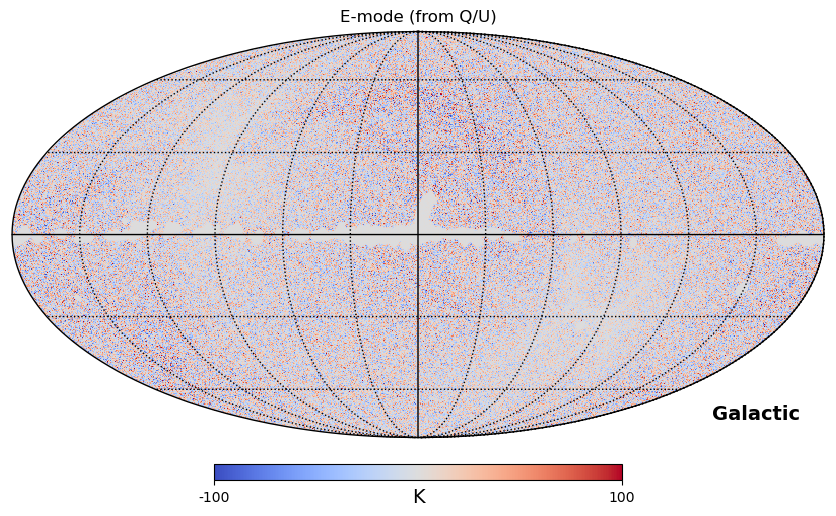

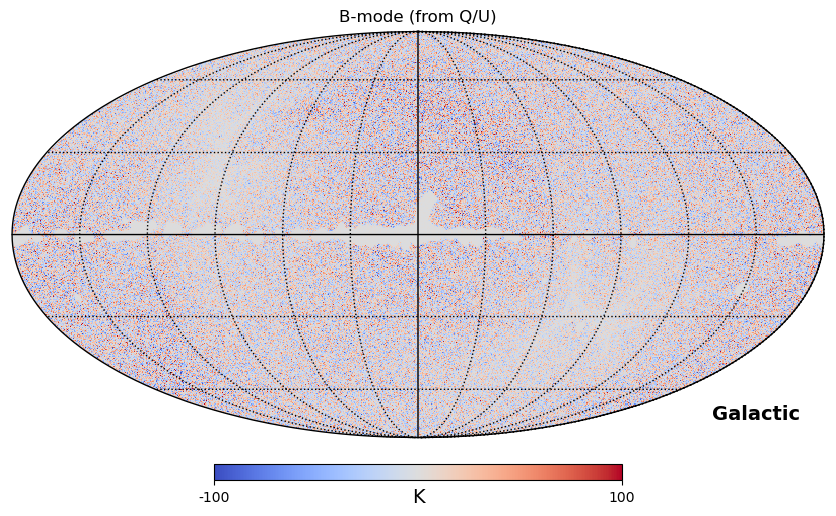

In [11]:
E, B = qu_to_eb_maps(Q, U)
show_map(E, title="E-mode (from Q/U)", unit="K", coord='G', minmax=(-100,100))
show_map(B, title="B-mode (from Q/U)", unit="K", coord='G', minmax=(-100,100))

### 2.5. Intensity and Polarization masks (TMASK/PMASK)
---
These visualizations show the TMASK and PMASK maps, which define the sky regions retained for temperature and polarization analyses, respectively. The masks are used to exclude areas contaminated by Galactic foregrounds and point sources, ensuring a cleaner extraction of the cosmological signal

Unmasked sky fraction (Temperature): 0.842
Unmasked sky fraction (Polarization): 0.929


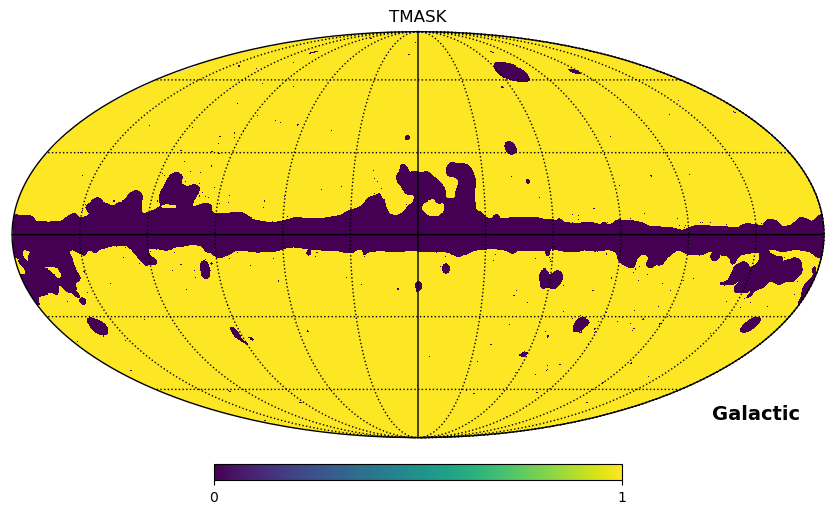

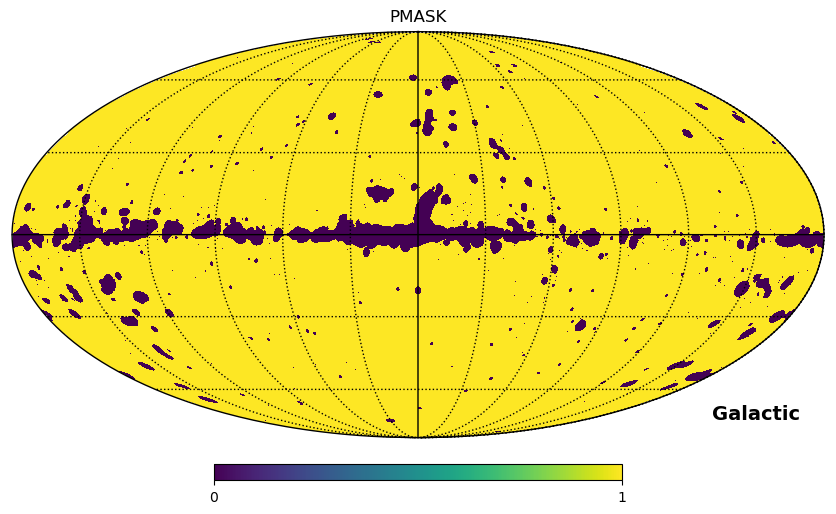

In [12]:
# Compute the fraction of the sky that is not masked (temperature)
f_sky = np.mean(maps['TMASK'])  # Fraction of unmasked sky for temperature
print(f"Unmasked sky fraction (Temperature): {f_sky:.3f}")

# Visualize the temperature mask
show_map(maps['TMASK'], title="TMASK", unit="", coord='G', cmap='viridis')

# Compute the fraction of the sky that is not masked (polarization)
f_sky = np.mean(maps['PMASK'])  # Fraction of unmasked sky for polarization
print(f"Unmasked sky fraction (Polarization): {f_sky:.3f}")

# Visualize the polarization mask
show_map(maps['PMASK'], title="PMASK", unit="", coord='G', cmap='viridis')

## 3. CMB Power Spectrum
---
**1. Spherical Harmonic Decomposition:**
The map is expanded in terms of spherical harmonics $ Y_{\ell m}(\hat{n}) $:
$$ \Delta T(\hat{n}) = \sum_{\ell=0}^{\infty} \sum_{m=-\ell}^{\ell} a_{\ell m} Y_{\ell m}(\hat{n}) $$
The coefficients $ a_{\ell m} $ are obtained through the inverse transform (projection onto spherical harmonics):
$$ a_{\ell m} = \int \Delta T(\hat{n}) Y_{\ell m}{(\hat{n})} , d\Omega $$
where $ d\Omega = \sin\theta , d\theta , d\phi $ is the solid angle element, and $ * $ denotes complex conjugation. In practice, for discrete maps (such as those in HEALPix format), this integral is approximated as a sum over pixels:
$$ a_{\ell m} \approx \sum_{i=1}^{N_{\text{pix}}} \Delta T_i , Y_{\ell m}(\theta_i, \phi_i) , \Delta \Omega_i $$
In HEALPix, all pixels have the same area $ \Delta \Omega_i = 4\pi / N_{\text{pix}} $, where $ N_{\text{pix}} = 12 \times n_{\text{side}}^2 $ and $ n_{\text{side}} $ is the resolution parameter.

**2. Power Spectrum $ C_\ell $:**
The power spectrum is the average of the squared coefficients $ a_{\ell m} $ over the $ 2\ell + 1 $ values of $ m $:
$$ C_\ell = \frac{1}{2\ell + 1} \sum_{m=-\ell}^{\ell} |a_{\ell m}|^2 $$
This assumes statistical isotropy (the CMB is homogeneous on average). In practice, corrections are applied for effects such as noise, beam resolution, and masks (excluded sky regions).

**3.Additional Considerations:**

- **Limit in $ \ell $**: The value of $ \ell_{\max} $ depends on the map resolution; typically $ \ell_{\max} \approx 3 \times n_{\text{side}} $.
- **Normalization:** It is common to multiply by factors such as $ \ell(\ell+1)/2\pi $ to plot the spectrum in terms of $ D_\ell $, which highlights the acoustic oscillations.
- **Noise and Corrections:** For real data, estimators such as maximum likelihood or pseudo-$ C_\ell $ are used to properly handle noise and incomplete sky coverage.

### 3.1. Compute the $C_l$ coefficients using the healpy library
---
**anafast:**

- anafast is a high-level routine that computes the angular power spectrum directly from a HEALPix map by first performing the spherical-harmonic transform to obtain the coefficients $a_{\ell m}$ and then forming
$$ C_\ell = \frac{1}{2\ell + 1}\sum_{m=-\ell}^{\ell} |a_{\ell m}|^2 $$

- It can be applied to temperature maps (TT spectrum) and, when provided with polarization information (Q/U), it can also be used to obtain polarization-related spectra (e.g., EE, BB, TE), depending on the input configuration.

- For realistic analyses, it is common to use anafast together with a mask (by masking the map values) and then apply corrections for incomplete sky coverage (pseudo-$C_\ell$ approach), beam smoothing, and pixel window functions.

- The maximum multipole is typically chosen as $ \ell_{\max} \approx 3 \times n_{\text{side}} $, ensuring that the spectrum is computed consistently with the map resolution.

In [13]:
def compute_cmb_spectrum(
    I_map,                  # Temperature (Stokes I) HEALPix map: ΔT(n)
    lmax=None,              # Maximum multipole; default = 3*nside - 1
    map_units="uK",         # "uK" if map is in micro-Kelvin, "K" if map is in Kelvin
    tmask=None,             # Optional temperature mask (0/1 or [0,1] weights)
    apply_fsky_correction=True,  # Simple pseudo-Cl correction: divide by f_sky (rough)
    remove_monopole=True,   # Remove ℓ=0 contribution (recommended)
    remove_dipole=True      # Remove ℓ=1 contribution (often recommended)
):
    """
    Compute the CMB angular power spectrum from a HEALPix temperature map.

    This function computes:
      - C_l  via healpy.anafast (spherical-harmonic transform + power estimate)
      - D_l = l(l+1) C_l / (2π)   (common plotting convention)

    Notes (important in practice):
    - If a mask is applied, the result is a *pseudo*-C_l. A simple f_sky correction
      (division by the unmasked sky fraction) is a crude approximation and does NOT
      fully correct mode-coupling.
    - Units: if the input map is in K, C_l is in K^2 and D_l is in K^2. If the map is in μK,
      outputs are in μK^2 (or can be converted consistently).

    Parameters
    ----------
    I_map : np.ndarray
        HEALPix temperature anisotropy map (Stokes I), typically ΔT in K or μK.
    lmax : int or None
        Maximum multipole. If None, uses lmax = 3*nside - 1 (HEALPix Nyquist-like limit).
    map_units : str
        "uK" or "K". Controls unit conversion for the output spectra.
    tmask : np.ndarray or None
        Optional mask to apply (same length as I_map). Values typically 0/1 (binary) or [0,1] weights.
    apply_fsky_correction : bool
        If True and a mask is provided, divide C_l and D_l by f_sky = mean(mask).
        This is a rough correction only.
    remove_monopole : bool
        If True, remove ℓ=0 contribution by setting C_0 = 0 (recommended for anisotropy maps).
    remove_dipole : bool
        If True, remove ℓ=1 contribution by setting C_1 = 0 (often recommended unless dipole is modeled).

    Returns
    -------
    results : dict
        Dictionary with keys: "lmax", "nside", "ell", "Cl", "Dl", "f_sky", "unit_scale".
    """
    # -------------------------
    # 1) Infer map resolution
    # -------------------------
    nside = hp.get_nside(I_map)
    npix = len(I_map)

    # Default multipole cut based on HEALPix resolution
    if lmax is None:
        lmax = 3 * nside - 1

    # -------------------------
    # 2) Unit handling
    # -------------------------
    # If map is in Kelvin and we want μK^2 outputs, multiply by (1e6)^2.
    # If map is already in μK, keep as-is.
    if map_units.lower() == "uk":
        unit_scale = 1.0
        out_unit = "μK^2"
    elif map_units.lower() == "k":
        unit_scale = (1e6)**2
        out_unit = "μK^2 (converted from K)"
    else:
        raise ValueError("map_units must be 'uK' or 'K'.")

    # -------------------------
    # 3) Apply mask (optional)
    # -------------------------
    f_sky = None
    I_used = I_map

    if tmask is not None:
        if len(tmask) != npix:
            raise ValueError("tmask must have the same length as I_map (same Npix).")

        # Compute unmasked sky fraction (for binary masks: fraction of ones)
        f_sky = float(np.mean(tmask))

        # Multiply the map by the mask (pseudo-Cl approach)
        I_used = I_map * tmask

    # -------------------------
    # 4) Compute C_l using anafast
    # -------------------------
    # healpy.anafast returns C_l for l=0..lmax
    cls = hp.anafast(I_used, lmax=lmax)

    # Optionally remove monopole/dipole (common for anisotropy analyses)
    if remove_monopole and len(cls) > 0:
        cls[0] = 0.0
    if remove_dipole and len(cls) > 1:
        cls[1] = 0.0

    # Convert to μK^2 if needed
    Cl = cls * unit_scale

    # -------------------------
    # 5) Compute D_l
    # -------------------------
    ell = np.arange(len(cls))
    Dl = ell * (ell + 1) * cls / (2 * np.pi) * unit_scale

    # -------------------------
    # 6) Simple f_sky correction (optional, rough)
    # -------------------------
    # This is NOT a full correction for mask-induced mode coupling.
    if (tmask is not None) and apply_fsky_correction and (f_sky is not None) and (f_sky > 0):
        Cl = Cl / f_sky
        Dl = Dl / f_sky

    # -------------------------
    # 7) Pack results
    # -------------------------
    results = {
        "lmax": lmax,
        "nside": nside,
        "unit_scale": unit_scale,
        "output_unit": out_unit,
        "f_sky": f_sky,
        "ell": ell,
        "Cl": Cl,
        "Dl": Dl,
    }

    return results

    

In [14]:
# Remove the monopole (ℓ = 0) and dipole (ℓ = 1) components from the temperature map
# and apply the temperature mask to exclude contaminated sky regions
I_mask = hp.remove_dipole(hp.remove_monopole(I)) * maps['TMASK']

# Extract the HEALPix resolution parameter from the map
nside = hp.get_nside(I)

# Set the maximum multipole according to the map resolution (Nyquist-like limit)
lmax = 3 * nside - 1

# Print basic information about the dataset
print('Data size (number of pixels):', I.shape)
print('NSIDE parameter:', nside)
print('Maximum multipole:', lmax)

# Compute the angular power spectrum from the masked temperature map
results = compute_cmb_spectrum(
    I_mask,
    lmax=None,   # If None, lmax is automatically set to 3*nside - 1
)

# Report how many multipoles have been computed
print('Number of computed multipoles:', len(results['Cl']))


Data size (number of pixels): (50331648,)
NSIDE parameter: 2048
Maximum multipole: 6143
Number of computed multipoles: 6144


### 3.2. Avergage $D_l$ values on uniform bins
---
This block performs a binning of the CMB power spectrum by averaging the values of $D_l$ over uniform multipole intervals of width $\Delta \ell$. The binning procedure reduces statistical fluctuations and makes the acoustic peak structure more clearly visible.

- Only multipoles with $\ell \geq 2$ are considered, excluding the monopole and dipole contributions.
- For each bin, an effective multipole value and the corresponding mean power are computed.
- The resulting binned spectrum is stored in the results dictionary for subsequent visualization and analysis.

In [15]:
def bin_spectrum(results, dL=20):
    """
    Average D_l in uniform bins of width dL (ignoring ell < 2).
    """
    ell = results["ell"]
    Dl  = results["Dl"]

    # Select ell >= 2 (exclude monopole and dipole)
    m = (ell >= 2)

    eb, Db = [], []

    # Define bin edges using dL
    L = np.arange(2, ell[m].max() + 1, dL)

    for a in L:
        sel = (ell >= a) & (ell < a + dL)
        if np.any(sel):
            eb.append(int(np.round(ell[sel].mean())))
            Db.append(Dl[sel].mean())

    results["ell_binned"] = np.asarray(eb)
    results["Dl_binned"]  = np.asarray(Db)
    results["dL"] = dL

    return results

In [16]:
results = bin_spectrum(results, dL=12)
print('Array Shape D_L Binned:', results["Dl_binned"].shape, len(results["ell_binned"]))


Array Shape D_L Binned: (512,) 512


## 4. Analysis
---
1. Acoustic Pics
2. Spectrum Visualization
3. Observables

### 4.1. Acoustic Pics
---
This part of the code identifies and refines the position of an acoustic peak in the binned CMB power spectrum. 
- It first searches for the global maximum within a specified multipole interval, corresponding to a given acoustic peak.
- A local quadratic fit is then applied around this maximum to obtain a sub-bin estimate of the peak position and amplitude.

This refinement improves the accuracy beyond the discrete multipole resolution of the data. The procedure is particularly useful for estimating the location of the first acoustic peak, which carries key information about the geometry of the Universe.

In [17]:
def quadratic_subpeak(x, y):
    """
    Perform a local quadratic fit y = a x^2 + b x + c to refine the position
    of a maximum. Returns (x_peak, y_peak) with sub-integer precision.
    Requires at least 3 points.
    """
    # Build the design matrix for the quadratic model
    A = np.vstack([x**2, x, np.ones_like(x)]).T

    # Solve the least-squares problem to obtain coefficients a, b, c
    a, b, c = np.linalg.lstsq(A, y, rcond=None)[0]

    # If the parabola opens upwards (a >= 0), return the discrete maximum
    # since a true maximum cannot be defined from the fit
    if a >= 0:
        i = np.argmax(y)
        return float(x[i]), float(y[i])

    # Compute the vertex of the parabola (refined peak position)
    x_peak = -b / (2 * a)

    # Evaluate the quadratic model at the peak position
    y_peak = a * x_peak**2 + b * x_peak + c

    return float(x_peak), float(y_peak)


def find_peak_in_window(ell, Dl, Lmin, Lmax, refine_width=8):
    """
    Find the dominant peak of D_l within the multipole range [Lmin, Lmax]
    and refine its position using a local quadratic fit over a window of
    ± refine_width multipoles.
    """
    # Ensure inputs are 1D float arrays
    ell = np.asarray(ell, dtype=float).ravel()
    Dl  = np.asarray(Dl,  dtype=float).ravel()

    # Select the multipole range of interest
    sel = (ell >= Lmin) & (ell <= Lmax)
    if not np.any(sel):
        return None, None

    # Identify the index of the maximum within the selected range
    i0 = np.argmax(Dl[sel])
    idxs = np.where(sel)[0]
    i_peak = idxs[i0]

    # Define a local window around the peak for refinement
    i1 = max(0, i_peak - refine_width)
    i2 = min(len(ell), i_peak + refine_width + 1)

    # Extract local multipoles and spectrum values
    xloc = ell[i1:i2].astype(float)
    yloc = Dl[i1:i2].astype(float)

    # Refine the peak position using a quadratic fit
    x_peak, y_peak = quadratic_subpeak(xloc, yloc)

    # Return integer-valued peak location and amplitude for reporting
    return int(np.round(x_peak)), int(np.round(y_peak))


In [18]:
# Initialize list to store detected acoustic peaks
results['peaks'] = []

# Define multipole ranges where the first acoustic peaks are expected
range_peaks = [(150, 300), (400, 650), (700, 900)]

# Search for peaks within each multipole interval using the binned spectrum
for rang in range_peaks:
    results['peaks'].append(
        find_peak_in_window(
            results['ell_binned'],
            results['Dl_binned'],
            rang[0],
            rang[1]
        )
    )

# Print the total number of detected peaks
print('Total number of detected peaks:', len(results['peaks']))

# Report the position and amplitude of each detected peak
for ix, (peak, value) in enumerate(results['peaks']):
    print(ix, '- Peak at multipole:', peak, '(Value =', "{:.1f}".format(value), ')')



Total number of detected peaks: 3
0 - Peak at multipole: 220 (Value = 4620.0 )
1 - Peak at multipole: 530 (Value = 1935.0 )
2 - Peak at multipole: 801 (Value = 1640.0 )


### 4.2. Spectrum Visualization
---

In [19]:
def plot_cmb_spectrum(
    results,
    annotate_peaks=True,
    show=True,    
    lmax_plot=None
):
    """
    Parámetros:
    - apply_gaussian_smooth: suavizado extra en l-space (sobre D_l binned)
    - smooth_sigma_l: sigma del kernel gaussiano en ell
    - annotate_peaks: anotar picos detectados
    - use_torch_smoothing: si True y hay torch, suaviza con conv1d gaussiana en GPU/CPU
    """

    # ---- Detección de picos en el D_l binned/suavizado ----
    ell = results['ell']
    Dl = results['Dl']
    ell_binned = results['ell_binned']
    Dl_binned = results['Dl_binned']
    ell_peaks = [ell[peak[0]] for peak in results['peaks']]
    Dl_peaks = [Dl[peak[1]] for peak in results['peaks']]
    
    if lmax_plot is None:
        lmax_plot = len(ell)
        
    # ---- Gráfica ----
    plt.figure(figsize=(9, 5.5))
    # Curva de alta resolución (gris claro)
    plt.plot(ell, Dl, lw=1, alpha=0.4, label=r"$D_\ell$ (no bin)")
    # Curva binned
    plt.plot(ell_binned, Dl_binned, lw=1.6, label=fr"$D_\ell$ binned ($\Delta\ell={results['dL']}$)")
    # Picos
    if annotate_peaks and len(ell_peaks) > 0:
     #  plt.scatter(ell_peaks, Dl_peaks, s=35, zorder=5, label="Picos detectados")
        # Anotar algunos picos destacados (primeros 4–5 típicos)
        order = np.argsort(Dl_peaks)[::-1]
        for k in order[:5]:
            lp, Dp = int(ell_peaks[k]), Dl_peaks[k]
            plt.axvline(ell_peaks[k], linestyle="dotted", color='black', linewidth=1.0)

            plt.annotate(fr"$\ell\!\approx\!{lp}$",
                         xy=(lp, Dp),
                         xytext=(lp+25, Dp*1.05),
                         arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8),
                         fontsize=10)

    plt.xlim(2, lmax_plot)
    plt.xlabel(r"Multipolo $\ell$", fontsize=13)
    plt.ylabel(r"$D_\ell=\dfrac{\ell(\ell+1)}{2\pi}C_\ell\;[\mu\mathrm{K}^2]$", fontsize=13)
    plt.title("Espectro de Potencias del CMB (picos acústicos)", fontsize=14)
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()


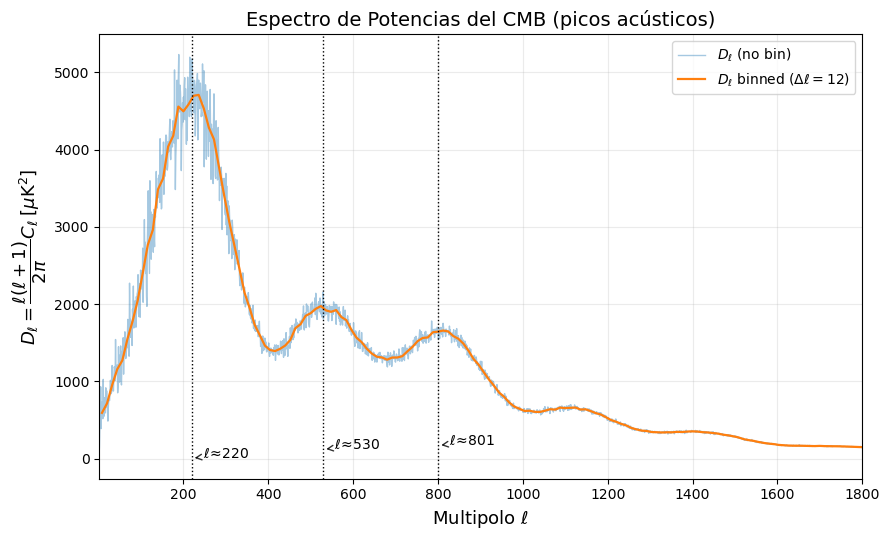

In [20]:
plot_out = plot_cmb_spectrum(
    results,
    annotate_peaks=True, 
    lmax_plot = 1800
)

## 4. Spectrum Analysis – Geometric Observables

---

The main geometric observables that can be extracted from the spectrum include:

* **Sound horizon** $ r_s(z_*) $: The comoving distance traveled by an acoustic wave until recombination.
  $$ r_s(z_*) = \int_0^{t_*} c_s dt / a(t) $$
  where: $ z_* \approx 1090 $ is the recombination redshift.
  $$ c_s = \frac{c}{\sqrt{3(1 + R)}} $$ is the sound speed in the plasma, $$ R = \frac{3\rho_b}{4\rho_\gamma} $$ is the baryon–photon ratio, and $ a(t) $ is the scale factor.

* **Angular diameter distance to last scattering** $ D_A $: It measures the curvature and expansion of the Universe.

$$ D_A(z_*) = \frac{1}{1+z_*} \int_0^{z_*} \frac{c , dz}{H(z)} $$
$$ H(z)=H_0\sqrt{\Omega_m(1+z)^3+\Omega_r(1+z)^4+\Omega_k(1+z)^2+\Omega_\Lambda}$$
in a flat Universe (for curved Universes, a curvature factor is included).

* **Angular acoustic scale** $ \theta_A $ (or $ \theta_* $): It represents the angle subtended by the acoustic horizon on the surface of last scattering (z ≈ 1090). It is a robust observable that measures the ratio between the sound horizon and the angular diameter distance.
  $$\theta_A = \frac{r_s(z_*)}{D_A(z_*)}$$

* **Acoustic multipole** $ \ell_A $: Related to $ \theta_A $ by $ \ell_A = \pi / \theta_A $, and it corresponds approximately to the position of the first peak or to the average spacing of the peaks.
  $$\ell_A = \pi \frac{D_A(z_*)}{r_s(z_*)}$$
  In standard ΛCDM models, $ \ell_A \approx 301 $ (from Planck measurements).

* **Phase-shift check:** it accounts for shifts induced by baryons and neutrinos. It is used as a diagnostic of the solution. Its value should lie in the range $[0.25, 0.3]$

$$\ell_1 ;\approx; \ell_A,\bigl(1 - \phi_1\bigr) \quad\Rightarrow\quad \widehat{\phi}_1 \approx 1-\frac{\ell_1}{\ell_A}$$


In [21]:
def acoustic_scale_from_peaks(results):
    # Extract multipoles and power spectrum (not explicitly used here,
    # but kept for consistency with the results structure)
    ell, Dl = results['ell'], results['Dl']

    # Compute the spacing between consecutive acoustic peaks
    d12 = results['peaks'][1][0] - results['peaks'][0][0]  # separation between 1st and 2nd peak
    d23 = results['peaks'][2][0] - results['peaks'][1][0]  # separation between 2nd and 3rd peak

    # Estimate the acoustic multipole ℓ_A as the average peak spacing
    lA = 0.5 * (d12 + d23)  # simple estimator of ℓ_A

    # Angular acoustic scale θ_* = π / ℓ_A (in radians)
    theta_star = np.pi / lA

    # Phase-shift diagnostic for the first peak:
    # measures deviation of the first peak position from ℓ_A
    phi1_hat = 1.0 - (results['peaks'][0][0] / lA)

    # Store intermediate spacings
    results["d12"] = d12
    results["d23"] = d23

    # Store acoustic multipole and angular scale
    results["lA"] = lA
    results["theta_star_rad"] = theta_star
    results["theta_star_arcmin"] = theta_star * (180 / np.pi) * 60.0  # convert to arcminutes

    # Store phase-shift estimator
    results["phi1_hat"] = phi1_hat

    # Store ratio D_A / r_s derived from ℓ_A = π D_A / r_s
    results["DA_over_rs"] = lA / np.pi

    return results


In [22]:

results = acoustic_scale_from_peaks(results)

print(f"Position of the first peak:        l_1 ≈ {results['peaks'][0][0]}")
print(f"Acoustic multipole spacing:     Δℓ ≈ ℓ_A ≈ {results['lA']:.1f}")
print(f"Angular acoustic scale:           θ_* ≈ {results['theta_star_arcmin']:.2f} arcmin")
print(f"Angular diameter / sound horizon: D_A / r_s ≈ {results['DA_over_rs']:.3f}")
print(f"Phase-shift diagnostic:           φ_1 ≈ {results['phi1_hat']:.3f}")

# Consistency check on the phase shift parameter
if (results['phi1_hat'] < 0.24 or results['phi1_hat'] > 0.30):
    print(
        "WARNING: Phase-shift parameter is outside the expected range [0.25, 0.30]. "
        "\n\t Possible Causes: beam effects, mask, noise level, or excessive smoothing."
    )


Position of the first peak:        l_1 ≈ 220
Acoustic multipole spacing:     Δℓ ≈ ℓ_A ≈ 290.5
Angular acoustic scale:           θ_* ≈ 37.18 arcmin
Angular diameter / sound horizon: D_A / r_s ≈ 92.469
Phase-shift diagnostic:           φ_1 ≈ 0.243


# License and Terms of Use
---
This code is distributed under the terms of the GNU General Public License (GPL).
You are free to use, modify, and redistribute it, provided that any derivative work is released under the same license and that proper credit is given to the original author.
The code is provided “as is”, without any warranty of any kind, express or implied.